🎯 El objetivo de esta implementación es utilizar vectores de representación generados mediante la técnica TF -IDF para clasificar requerimientos como funcionales o no funcionales.

#**Term Frequency - Inverse Document Frequency (TF-IDF)**

Cuenta las ocurrencias de las palabras en el texto y asigna un peso a cada término en función de su relevancia en el documento y en el corpus completo. Para ello, en primer lugar se calcula la Frecuencia de Término (TF):

\begin{equation}
    \text{TF}(t,d) = \frac{\text{Frecuencia del término t en el documento d}}{\text{Total de términos en d}}
\end{equation}

Posteriormente, se calcula la Frecuencia Inversa de Documento (IDF), que mide qué tan informativo es un término en relación con el corpus:

\begin{equation}
    \text{IDF}(t,D) = \ln \frac{\text{Total de documentos en D}}{\text{cantidad de documentos con el término t}}
\end{equation}

Finalmente, el valor TF–IDF se obtiene multiplicando ambos factores:

\begin{equation}
    \text{TF-IDF}(t,d,D) = \text{TF}(t,d) \times \text{IDF}(t,D)
\end{equation}

El resultado es una matriz término-documento en la que los valores más altos indican mayor relevancia de un término dentro de un documento específico. Para visualizar claramente cómo se calcula el TF-IDF, en la Figura solo se muestra el valor del término \textbf{casa} en el segundo documento; los demás valores se representan con ``\#'' para simplificar la ilustración.

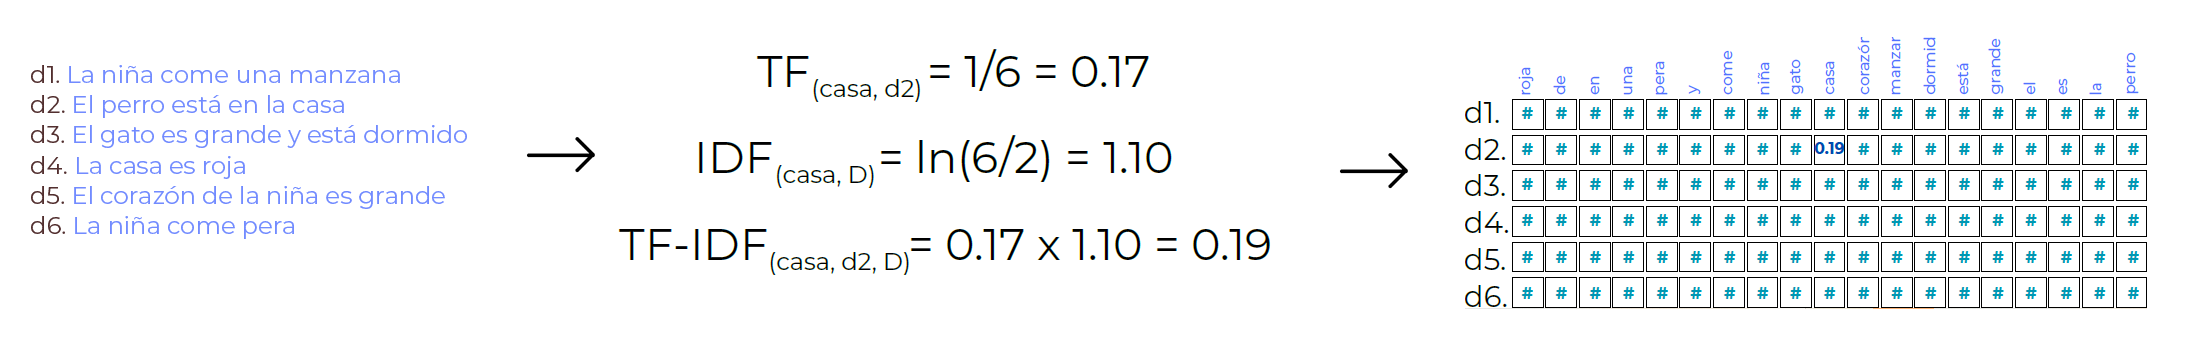

##Requerimientos

Los requerimientos de software son descripciones de las características con las que debe cumplir un sistema o programa para solucionar un problema. Estos pueden ser **funcionales** (decriben una funcionalidad específica) o **no funcionales** ( relacionado a como debe cumplir con dichas características).  

El conjunto de datos que se utilizarán en la presente implementación consta de 550 requerimientos en formato de texto. La etiqueta en la columna _'class'_ puede ser **_'fr'_** para requerimientos **funcionales** o  **_'nfr'_** para requerimientos **no funcionales**

Nota: El dataset en formato csv se puede descargar del repositorio de Github [CSV requerimientos](https://github.com/Yuritzi15/TF-IDF/blob/b0ae6c115ed5dc14a1abee88d98c142264a00988/data/Requerimientos.csv)

In [1]:
#Bibliotecas necesarias para la ejecución del código
#¡Asegurate de correr primero esta celda!
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import re
import math
from collections import Counter
import numpy as np
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Estos son algunos de los requerimientos que estaremos utilizando para clasificar.

In [2]:
#cargar el dataset
df=pd.read_csv('/content/Requerimientos.csv')
df.head()

,text,class
0,The transfer shall take place in such a manne...,fr
1,The BE shall receive via MC State Count data p...,fr
2,This includes Lag Frame destination addresses ...,fr
3,Formatted Output The BE shall deliver formatte...,fr
4,The BE shall produce all data needed by the ee...,fr


## Tareas de preprocesamiento

Las tareas de preprocesamiento de texto para este método de representación incluyen:

- **Tokenización**: separar los documentos en palabras.
- **Lowercasing**: normalizar en minúsculas todos los tokens.
- **Remover Stopwords**: eliminar las palabras que no aportan información ayuda a reducir la dimensionalidad de los vectores.

- **Stemming**: convertir los tokens a su forma de diccionario ayuda a reducir la dimensionalidad de los vectores.

- **Lematización**: eliminar los prefijos y sufijos en los tokens reduce dimensionalidad

A continuación se define la clase _PreprocesamientoTexto_ que realiza el procesamiento del texto.

In [3]:
#Esta clase define los pasos del preprocesamiento
class PreprocesamientoTexto:
  def __init__(self, aplicar_lowercase=True, remover_stopwords=True, aplicar_stemming=True, aplicar_lematizacion=True):
    #El constructor inicializa las opciones seleccionadas por el usuario
    self.aplicar_lowercase = aplicar_lowercase
    self.remover_stopwords = remover_stopwords
    self.aplicar_stemming = aplicar_stemming
    self.aplicar_lematizacion = aplicar_lematizacion

    #Inicializa las herramientas de NLTK
    self.stop_words = set(stopwords.words('english'))
    self.stemmer = PorterStemmer()
    self.lemmatizer = WordNetLemmatizer()

  def procesamiento(self, texto):
    #Tokenizar el texto en palabras
    tokens = word_tokenize(texto)

    #Paso 1: Eliminar signos de puntuación
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
    tokens = [token for token in tokens if token]

    #Paso 2: Lowercasing
    if self.aplicar_lowercase:
      tokens = [token.lower() for token in tokens]

    #Paso 3: Remover Stopwords
    if self.remover_stopwords:
      tokens = [token for token in tokens if token not in self.stop_words]

    #Paso 4: Stemming
    if self.aplicar_stemming:
      tokens = [self.stemmer.stem(token) for token in tokens]

    #Paso 5: Lematización
    if self.aplicar_lematizacion:
      tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

    return tokens


Puedes experimentar modificando los pasos del preprocesamiento, cuando el valor sea _True_ se realizará el paso, cuando sea _False_ no se realizará. Compara los tokens y el vocabulario resultantes.

In [4]:
#Cambia los valores a False o True y compara los resultados
preprocesador=PreprocesamientoTexto(
    aplicar_lowercase=True,
    remover_stopwords=True,
    aplicar_stemming=True,
    aplicar_lematizacion=False
)

#aplica el preprocesamiento
df['tokens']=df['text'].apply(preprocesador.procesamiento)

#crea el vocabulario
todos_los_tokens = []
for lista_tokens in df['tokens']:
  todos_los_tokens.extend(lista_tokens)
vocabulario=sorted(set(todos_los_tokens))

print("Vocabulario:",vocabulario)
print("Tamaño del vocabulario:",len(vocabulario))

Vocabulario: ['abid', 'abil', 'abl', 'abnorm', 'abstract', 'accept', 'access', 'accommod', 'accompani', 'accomplish', 'accord', 'accordingli', 'account', 'accumul', 'accur', 'accuracyth', 'achiev', 'acknowledg', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adapt', 'add', 'addedit', 'addit', 'addremov', 'address', 'adequ', 'adjust', 'admin', 'administr', 'adminus', 'admiss', 'adopt', 'advanc', 'advantag', 'advis', 'affect', 'afterward', 'age', 'agent', 'aggreg', 'aid', 'aip', 'ajax', 'alert', 'aliv', 'alloc', 'allow', 'along', 'also', 'alter', 'altern', 'alway', 'among', 'amount', 'analys', 'analysi', 'andor', 'android', 'anoth', 'answer', 'anyon', 'anyth', 'apach', 'api', 'app', 'appear', 'appl', 'appli', 'applic', 'approach', 'appropri', 'approv', 'arat', 'architectur', 'archiv', 'area', 'aris', 'around', 'arrang', 'ase', 'ask', 'aspect', 'assembl', 'assign', 'assist', 'associ', 'assum', 'assumpt', 'assur', 'attack', 'attempt', 'attend', 'attribut', 'audit', 'auditor'

##Clase TFIDF

Esta clase recibe el vocabulario generado anteriormente y resalta las palabras discriminatorias de cada documento y penaliza a las palabras más frecuentes que no aportan mucha información.

In [5]:
class TFIDF:
  def __init__(self, tokenized_documents,vocab):
        #recibe los documentos ya tokenizados
        self.documents = tokenized_documents
        #conteo de los documentos totales
        self.N = len(tokenized_documents)
        #inicialización del vocabulario
        self.vocab = vocab
        #tamaño del vocabulario
        self.vocab_size = len(self.vocab)
        #ejecutar los cálculos
        self.df = self.comptue_df()
        self.idf = self.compute_idf()
        self.tfidf_vectors = self.compute_tfidf_vectors()

  #calcula la frecuencia de los términos en todos los documentos
  def compute_df(self):
      df = {term: 0 for term in self.vocab}
      for doc in self.documents:
          unique_terms = set(doc)
          for term in unique_terms:
              df[term] += 1
      return df

  #calcula la frecuencia inversa de documentos
  def compute_idf(self):
      return {
          term: math.log(self.N / (1 + df_t))  # se suma 1 para evitar división por cero
          for term, df_t in self.df.items()
          }
  #calcula la frecuencia de termino
  def compute_tf(self, tokens):
      counts = Counter(tokens)
      total = len(tokens)
      return {term: counts.get(term, 0) / total for term in self.vocab}

  #calcula un solo vector tf-idf
  def compute_tfidf_vector(self, tokens):
      tf = self.compute_tf(tokens)
      return [tf[term] * self.idf[term] for term in self.vocab]

  #calcula todos los vectores tf-idf para todos los documentos
  def compute_tfidf_vectors(self):
      return [self.compute_tfidf_vector(doc) for doc in self.documents]

  #regresa los vectores TF-IDF
  def get_vectors(self):
      return self.tfidf_vectors

  # construye la matriz termino documento a partir de los vectores TF-IDF calculados
  def get_tfidf_matrix(self):
    tfidf_matrix = self.compute_tfidf_vectors()
    return pd.DataFrame(tfidf_matrix, columns=self.vocab)


El objeto _calculador_tfidf_ es una instancia de la clase TFIDF que recibe los documentos y el vocabulario generados por el objeto _preprocesador_ que es una instancia de la clase _PreprocesamientoTexto_. A través de este objeto se calcula la **matriz termino - documento**, en la cual cada columna representa un término y las filas representan los documentos.

In [10]:
#instancia TF_IDF que recibe los tokens y el vocabulario
calculador_tfidf = TFIDF(df['tokens'],vocabulario)

#calculo de los vectores TFIDF
df['tfidf'] = calculador_tfidf.get_vectors()

#calculo de la matriz termino documento
tf_idf_matrix = calculador_tfidf.get_tfidf_matrix()
print("Matriz termino - documento:")
tf_idf_matrix

Matriz termino - documento:


,abid,abil,abl,abnorm,abstract,accept,access,accommod,accompani,accomplish,...,word,work,workstat,worri,would,write,wwwusabilitygov,x,yet,zero
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.0,0.0,0.095843,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.564542,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Clasificación
Para realizar la clasificación de requerimientos utilizaremos un clasificador random forest. Por lo cual es necesario convertir los vectores de TFIDF en vectores de características que alimentarán el clasificador. Se realiza una división del dataset destinando el 80% al entrenamiento y 20% a las pruebas.

In [11]:
#Convertir las series de pandas a array
X = np.array(df['tfidf'].tolist())  # Vector de características
y = df['class']                     # etiquetas

# Split dataset (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_d2v_s = RandomForestClassifier(random_state=42) #Ejemplo
clf_d2v_s.fit(X_train, y_train)
y_pred = clf_d2v_s.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          fr       0.89      0.74      0.81        54
         nfr       0.78      0.91      0.84        56

    accuracy                           0.83       110
   macro avg       0.84      0.83      0.83       110
weighted avg       0.84      0.83      0.83       110

